In [1]:
# Installing dependencies
!pip install datasets contractions transformers scikit-learn seaborn matplotlib nltk
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 

In [2]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import Dataset
from google.colab import drive
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from torch.nn import CrossEntropyLoss
from transformers import TrainerCallback

In [4]:
# Mounting drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/mental_health_dataset.csv")

Mounted at /content/drive


In [5]:
# Dropping unnamed columns
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

# Taking 6000 samples from the dataset for training
data = data.sample(n=6000,).reset_index(drop=True)

data

,statement,status
0,ready for what?,Normal
1,How do you cope with your past? I want to know...,Bipolar
2,Do you ever feel like you’re in a losing battl...,Stress
3,Depakote + weed? I honestly haven't smoked wee...,Bipolar
4,I am 21m with no job or experience been job se...,Depression
...,...,...
5995,"wts photopack mark 127 ridi ina sealed hihi, p...",Normal
5996,"Haha, it turns out that we were just cloaked i...",Normal
5997,it could be something you saw you heard you di...,Depression
5998,"Its one of my moms brothers wedding, and I nev...",Suicidal


In [6]:
# Download NLTK stopwords (only needed once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    if not isinstance(statement, str):
        return ""
    statement = contractions.fix(statement)
    statement = statement.lower()
    statement = statement.translate(str.maketrans('', '', string.punctuation))
    statement = re.sub(r'\s+', ' ', statement).strip()
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['statement'] = data['statement'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status
0,ready,Normal
1,cope past want know cope past like general tra...,Bipolar
2,ever feel like losing battle doctor job two bl...,Stress
3,depakote weed honestly smoked weed since start...,Bipolar
4,21m job experience job searching 34 months not...,Depression
...,...,...
5995,wts photopack mark 127 ridi ina sealed hihi pl...,Normal
5996,haha turns cloaked articles,Normal
5997,could something saw heard anything go may good...,Depression
5998,one moms brothers wedding never wanted go trea...,Suicidal


In [7]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [8]:
# Train test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['statement'], data['label'], test_size=0.2, stratify=data['label'], random_state=42
)

In [9]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})

In [11]:
# Compute class weights
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
normalized_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

In [25]:
# from transformers import BertForSequenceClassification
# import torch.nn as nn
# import torch

# class WeightedBertForSequenceClassification(BertForSequenceClassification):
#     def __init__(self, config, class_weights=None):
#         super().__init__(config)
#         self.class_weights = class_weights

#     def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
#         # Remove unsupported keys (e.g., from Trainer)
#         kwargs = {k: v for k, v in kwargs.items() if k in ['token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds']}

#         outputs = super().forward(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             labels=labels,
#             **kwargs
#         )

#         # Override loss with weighted loss if class_weights are given
#         if labels is not None and self.class_weights is not None:
#             loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
#             loss = loss_fct(outputs.logits, labels)
#             return {'loss': loss, 'logits': outputs.logits}

#         return outputs

In [31]:
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch

class BertWithWeightedLoss(BertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove unsupported keys (e.g., from Trainer)
        kwargs = {k: v for k, v in kwargs.items() if k in ['token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds']}

        # Remove num_items_in_batch from kwargs if present
        kwargs.pop('num_items_in_batch', None)

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            **kwargs
        )

        # Override loss with weighted loss if class_weights are given
        if labels is not None and self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
            loss = loss_fct(outputs.logits, labels)  # Calculate weighted loss
            outputs.loss = loss  # Update the loss in the outputs
            return outputs  # Return the updated outputs

        return outputs  # Return the original outputs if no weighted loss is applied

In [32]:
from transformers import BertConfig
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model = BertWithWeightedLoss.from_pretrained('bert-base-uncased', config=config, class_weights=class_weights_tensor)

Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Define compute_metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [34]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    gradient_accumulation_steps=1,
    report_to="none"
)

In [35]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-35-fb26c53af097>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.565400,1.570808,0.546667,0.519698,0.606913,0.546667
2,1.152500,0.942578,0.667500,0.671983,0.723860,0.667500
3,0.698400,0.877980,0.703333,0.704879,0.742242,0.703333
4,0.391700,0.911533,0.721667,0.723507,0.736950,0.721667
5,0.650400,0.888281,0.728333,0.730656,0.741203,0.728333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1500, training_loss=0.9235574359893799, metrics={'train_runtime': 866.8196, 'train_samples_per_second': 27.687, 'train_steps_per_second': 1.73, 'total_flos': 2466776880000000.0, 'train_loss': 0.9235574359893799, 'epoch': 5.0})

In [37]:
# Predictions
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [38]:
# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

                      precision    recall  f1-score   support

             Anxiety       0.65      0.82      0.72        91
             Bipolar       0.65      0.81      0.72        67
          Depression       0.78      0.47      0.58       356
              Normal       0.94      0.86      0.90       367
Personality disorder       0.33      0.61      0.43        23
              Stress       0.45      0.73      0.56        60
            Suicidal       0.56      0.74      0.64       236

            accuracy                           0.70      1200
           macro avg       0.62      0.72      0.65      1200
        weighted avg       0.74      0.70      0.70      1200



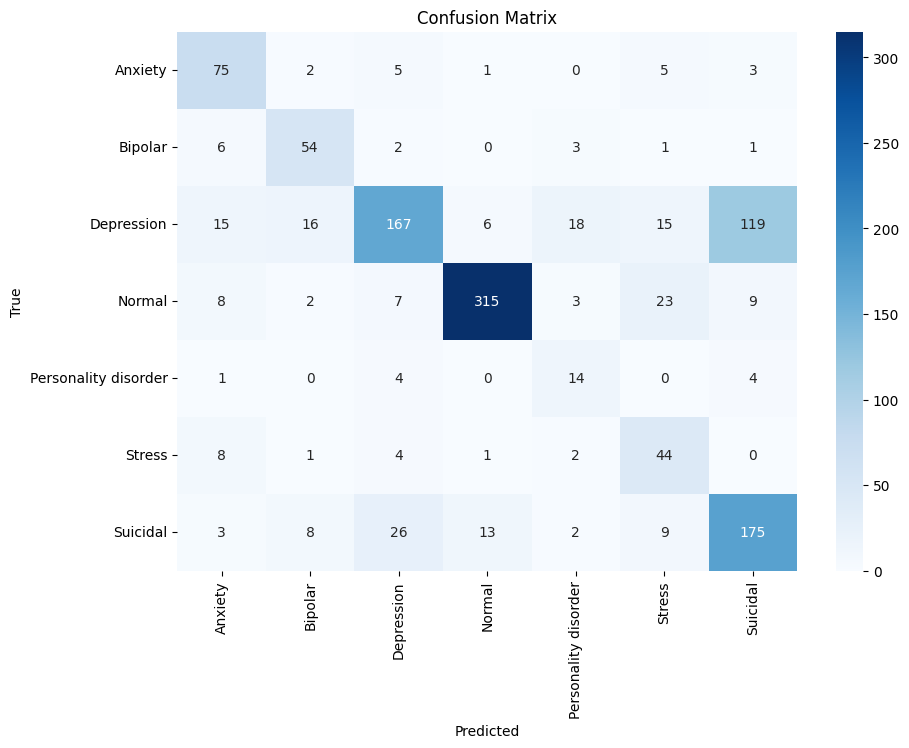

In [39]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Save the trained model, tokenizer, and label encoder
trainer.save_model("./saved_mental_status_bert")
tokenizer.save_pretrained("./saved_mental_status_bert")

('./saved_mental_status_bert/tokenizer_config.json',
 './saved_mental_status_bert/special_tokens_map.json',
 './saved_mental_status_bert/vocab.txt',
 './saved_mental_status_bert/added_tokens.json')

In [41]:
import pickle
pickle.dump(label_encoder, open('./saved_mental_status_bert_label_encoder.pkl', 'wb'))

# Load back model and tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("./saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("./saved_mental_status_bert")
label_encoder = pickle.load(open('./saved_mental_status_bert_label_encoder.pkl', 'rb'))

In [42]:
# Detection System
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

In [43]:
# Test detection
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

In [44]:
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Suicidal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Anxiety

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Depression

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Depression

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Suicidal

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Depression

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  0.7033
F1 Score:  0.7049
Precision: 0.7422
Recall:    0.7033


In [47]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# ✅ Create a zip archive of the folder
shutil.make_archive(zip_file_path, 'zip', root_dir=zip_file_path)

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>